# Importing the Neccesary libraries

In [444]:
from cosmosis.runtime.pipeline import LikelihoodPipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.gaussian_process.kernels import ExpSineSquared as Exp, RBF, ConstantKernel as C, RationalQuadratic,WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import cross_val_predict
from cosmosis.runtime.config import Inifile
from sklearn.decomposition import PCA
import numpy as np
from scipy.stats import qmc
import time
import csv
import pandas as pd

In [3]:
inifile = 'pipeline1.ini'
ini = Inifile(inifile) 

In [4]:
pipeline = LikelihoodPipeline(ini) 

Loading number density data from /Users/oluseyiolusegun/Downloads/cosebis_KIDS1000_BlindC_with_m_bias_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_goldclasses_Flag_SOM_Fid.fits:
    Looking at FITS extension NZ_SOURCE:
        Found 5 bins
        Putting n(0) = 0 at the start of the n(z)
Calculating Limber: Kernel 1 = ('F', 'source'), Kernel 2 = ('F', 'source'), P_3D = MatterPower3D  --> Output: shear_cl
Will project these spectra into 2D:
    -  shear_cl




*********in COSEBIs interface setup*********

Could not load input_section_name to COSEBIs,setting to default: shear_cl
got the value of output_section_name:cosebis
Caluclating E-modes
got the value of theta_min=0.5
got the value of theta_max=300
got the value of n_max=5
not using c_term correction
WnLog folder name is:/Users/oluseyiolusegun/Downloads/WnLog/
Root and Norms folder name is:/Users/oluseyiolusegun/Downloads/cosebis_cosmosis//TLogsRootsAndNorms/
T_pm folder name is:/Users/oluseyiolusegun/Downloads/cosebis_cosmosis//TpnLog/
in COSEBIs initialize
setting En parameters in COSEBIs
nMaximum=5
theta_min=0.000145444
theta_max=0.0872665
Wn not set setting now:
setting thetamin,thetamax,nMax
nMax=5
reading T1  roots	reading T1  normalization
reading T2  roots	reading T2  normalization
reading T3  roots	reading T3  normalization
reading T4  roots	reading T4  normalization
reading T5  roots	reading T5  normalization
set order of WnLog
LLOW=0 LHIGH=11.6491 NLBINS=1000000
log [0,11.64

Setup all pipeline modules
Module timing:
sample_S8 0.025639
sigma8toAs 0.024151
camb 0.026540
load_nz_fits 0.510378
extrapolate_power 0.023465
linear_alignment 0.024635
projection 0.025809
cosebis 15.655077

Parameter Priors
----------------
cosmological_parameters--omch2      ~ U(0.051, 0.255)
cosmological_parameters--ombh2      ~ U(0.019, 0.026)
cosmological_parameters--h0         ~ U(0.64, 0.82)
cosmological_parameters--n_s        ~ U(0.84, 1.1)
cosmological_parameters--s_8_input  ~ U(0.1, 1.3)
cosmological_parameters--omega_k    ~ delta(0.0)
cosmological_parameters--w          ~ delta(-1.0)
cosmological_parameters--wa         ~ delta(0.0)
cosmological_parameters--mnu        ~ delta(0.06)
halo_model_parameters--logt_agn     ~ U(7.6, 8.0)
intrinsic_alignment_parameters--a   ~ U(-6.0, 6.0)



In [9]:
pipeline.set_fixed('halo_model_parameters', "logt_agn", 2.6)
pipeline.set_fixed('intrinsic_alignment_parameters', "a", 1)

In [10]:
param_names_fixed = pipeline.fixed_params
param_names_fixed

[cosmological_parameters--omega_k,
 cosmological_parameters--w,
 cosmological_parameters--wa,
 cosmological_parameters--mnu,
 halo_model_parameters--logt_agn,
 intrinsic_alignment_parameters--a]

## obtaining the Theoretical predictions based on the fiducial values

In [13]:
params_fiducial = pipeline.start_vector()
# run the pipeline for the given parameters. All results are saved in block
block    = pipeline.run_parameters(params_fiducial)
stats_name_cosmosis ="cosebis"
# read in cosebis from block
nbin_a=block["shear_cl","nbin_a"]
nbin_b=block["shear_cl","nbin_b"]
counter=0
for i_bin in range(1,nbin_a+1): 
	for j_bin in range(1,nbin_b+1): 
		name_in="bin_"+str(j_bin)+("_")+str(i_bin)
		if(block.has_value(stats_name_cosmosis, name_in)):
			th = block[stats_name_cosmosis,name_in]
			if(counter==0):
				th_all=th.copy()
			else:
				th_all=np.hstack((th_all,th))
			counter+=1


sample_S8 took: 0.000 seconds
sigma8toAs took: 0.740 seconds
camb took: 5.958 seconds
load_nz_fits took: 0.001 seconds
extrapolate_power took: 0.093 seconds
linear_alignment took: 0.006 seconds
projection took: 0.922 seconds
cosebis took: 0.721 seconds
Total pipeline time: 8.44 seconds
Pipeline ran okay.


# Latin Hypercube Sampling

In [17]:

sample = [] 

def latinhypercube():
    time1 = time.time()
    
    #define an empty list to store the new sampled cosmological parameters
  
    
    #generate the latinhypercube with five(5) parameters and one random value from each set
    s = qmc.LatinHypercube(d= 5)
    sam = s.random(n=150)
    
    #specify the lower bound and upper bound of each cosmological parameter(omch2,ombh2) from the values.ini file
    l_bounds =[0.051 , 0.019 , 0.64  , 0.84 , 0.1]
    u_bounds = [0.255 , 0.026 , 0.82  , 1.1 , 1.3]
    
    #scale the generated samples to the lower bound and upper bounds of each parameter
    lhs=qmc.scale(sam, l_bounds,u_bounds)
    
    # append the scaled samples to the created empty list
    sample.append(lhs)
    time2= time.time()
    time3 = time2 - time1
    print('time taken is', time3)
    
    
    
    #return params_fucidial_samp
latinhypercube()



time taken is 0.0008509159088134766


In [19]:
params = sample[0]
new_params = params.tolist()
New_params = pd.DataFrame(new_params)
New_params.columns=['omch2', 'ombh2', 'h0','n_s', 's8_input']
New_params.index= np.arange(1, len(New_params) + 1)
New_params.to_csv('cosmological_params1.csv')

In [722]:
 import matplotlib.gridspec as gridspec

In [899]:
#fucntion for visualizing the Latin hypercube sampled cosmological parameters
def Plot_latin(coords,labels,limits):
        
        import matplotlib.gridspec as gridspec
        if labels == None or len(labels) != coords.shape[1]:
            new_labels = []
            for i in range(coords.shape[0]):
                new_labels.append('X%s'%i)
            labels = new_labels

        

        fig = plt.figure(figsize = (10,10)) #figsize = (20,14)
        gs1 = gridspec.GridSpec(coords.shape[1]-1,coords.shape[1]-1)
        p=0	# subplot number
        for i in range(coords.shape[1]-1):
            l=i+1 # which y-axis statistic is plotted on each row.	
            for j in range(coords.shape[1]-1):
                ax1 = plt.subplot(gs1[p])
                if j>i:
                    ax1.axis('off')
                else:
                    ax1.scatter(coords.iloc[:,j], coords.iloc[:,l], color='red',s=20)
                    color_idx=0
                    for s in range(coords[120:].shape[0]): 
                            ax1.scatter(coords.iloc[s,j], coords.iloc[s,l], color= 'blue', s=20 )
                            color_idx+=1

                    # Decide what the axis limits should be. If limits=None, it doesn't set any.
                    # If limits is [a,b], limits are set to be a*min and b*max in each dimension.
                    # Else, limits is interpreted as [ [x1,x2],[y1,y2],[z1,z2]...] for each dimension. 
                    if limits != None:
                        
                        ax1.set_xlim([ limits[j][0],limits[j][1] ]) 
                        ax1.set_ylim([ limits[l][0],limits[l][1] ])
                   


                    if j==0:
                        ax1.set_ylabel(labels[l])
                    else:
                        ax1.set_yticks([])
                    if i==coords.shape[1]-2:
                        ax1.set_xlabel(labels[j])
                    else:				
                        ax1.set_xticks([])
                p+=1
        fig.suptitle(r'Latin hypercube sampling of 150 Datasets' )
        
        
        plt.show()
        



In [900]:
labels = ['omch2','ombh2','h0','n_s' ,'s8']
limits = [[0.051,0.255],[0.019,0.026], [0.64,0.82],[0.84,1.1],[0.1,1.3]]


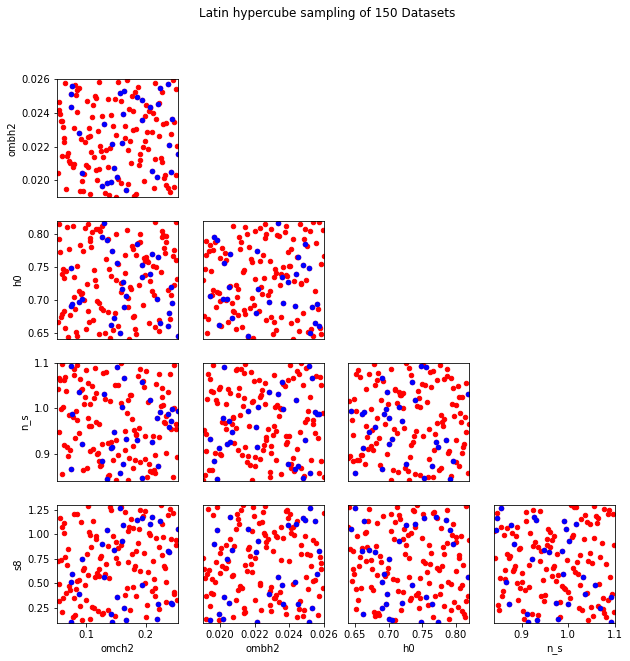

In [901]:
 Plot_latin(New_params,labels,limits)

 ## creating new theoretical predictions from the sampled parameters

In [20]:
%%time
data = []
time_1 = time.time()

for item in New_params.values.tolist():# this line passes all the sampled cosmological parameters into the pipeline
    block    = pipeline.run_parameters(item)
    stats_name_cosmosis ="cosebis"
        # read in cosebis from block
    nbin_a=block["shear_cl","nbin_a"]
    nbin_b=block["shear_cl","nbin_b"]
    counter=0
    for i_bin in range(1,nbin_a+1): 
        for j_bin in range(1,nbin_b+1): 
            name_in="bin_"+str(j_bin)+("_")+str(i_bin)
            if(block.has_value(stats_name_cosmosis, name_in)):
                th = block[stats_name_cosmosis,name_in]
                if(counter==0):
                    th_all=th.copy()

                else:
                    th_all=np.hstack((th_all,th))
                    data.append(th_all)
                counter+=1
time_2 = time.time()
time_3 = time_2 - time_1
print('Time Taken to Get Th_all prediction is', time_3)



sample_S8 took: 0.000 seconds
sigma8toAs took: 0.635 seconds
camb took: 6.105 seconds
load_nz_fits took: 0.001 seconds
extrapolate_power took: 0.090 seconds
linear_alignment took: 0.006 seconds
projection took: 0.838 seconds
cosebis took: 0.716 seconds
Total pipeline time: 8.39 seconds
Pipeline ran okay.
sample_S8 took: 0.000 seconds
sigma8toAs took: 0.528 seconds
camb took: 5.964 seconds
load_nz_fits took: 0.001 seconds
extrapolate_power took: 0.088 seconds
linear_alignment took: 0.006 seconds
projection took: 0.978 seconds
cosebis took: 0.732 seconds
Total pipeline time: 8.3 seconds
Pipeline ran okay.
sample_S8 took: 0.000 seconds
sigma8toAs took: 0.564 seconds
camb took: 6.142 seconds
load_nz_fits took: 0.001 seconds
extrapolate_power took: 0.087 seconds
linear_alignment took: 0.006 seconds
projection took: 0.997 seconds
cosebis took: 0.725 seconds
Total pipeline time: 8.52 seconds
Pipeline ran okay.
sample_S8 took: 0.000 seconds
sigma8toAs took: 0.467 seconds
camb took: 7.357 secon

/Users/oluseyiolusegun/Downloads/cosmosis-standard-library//structure/projection/projection_tools/kernel.py:154: RuntimeWarning: invalid value encountered in true_divide
  nchi_spline.y * (nchi_spline.x - chi)/nchi_spline.x, 0.)


projection took: 0.726 seconds
cosebis took: 0.653 seconds
Total pipeline time: 7.32 seconds
Pipeline ran okay.
sample_S8 took: 0.000 seconds
sigma8toAs took: 0.296 seconds
camb took: 5.035 seconds
load_nz_fits took: 0.001 seconds
extrapolate_power took: 0.084 seconds
linear_alignment took: 0.005 seconds
projection took: 0.771 seconds
cosebis took: 0.689 seconds
Total pipeline time: 6.88 seconds
Pipeline ran okay.
sample_S8 took: 0.000 seconds
sigma8toAs took: 0.333 seconds
camb took: 5.342 seconds
load_nz_fits took: 0.001 seconds
extrapolate_power took: 0.130 seconds
linear_alignment took: 0.008 seconds
projection took: 1.010 seconds
cosebis took: 0.817 seconds
Total pipeline time: 7.64 seconds
Pipeline ran okay.
sample_S8 took: 0.000 seconds
sigma8toAs took: 0.466 seconds
camb took: 6.345 seconds
load_nz_fits took: 0.001 seconds
extrapolate_power took: 0.098 seconds
linear_alignment took: 0.006 seconds
projection took: 1.002 seconds
cosebis took: 0.809 seconds
Total pipeline time: 8.

In [27]:
Train_file = []
for item in data:
    
    if len(item) == 75:
        Train_file.append(item)

# Scaling the new predicted values by dividing by the theoretical prediction of the fucidial values

In [902]:
new_data = Train_file / th_all

In [230]:
new_column_list = list(range(1, 76))

## Specifying the Training and Trial dataset

In [903]:
X_train = New_params[0:120]
X_test = New_params[120:]
y_train = new_data[0:120]
y_test = new_data[120:]
n_restarts_optimizer = 7

## Class for Building and  Assessing the performance of the GPR emulator

In [946]:
class GPR_Emulator:

    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train =  X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
    
    def GPR_Model(self,n_restarts_optimizer):
        '''- specify the kernel 
            -fit the Gaussian process emulator on the training dataset with n_restarts_optimizer of 7
            -Use the Gaussian model in predicting samples from the test data
        
        '''
        time_1 = time.time()
        kernel = 1 * RBF()
        
        model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=n_restarts_optimizer)
        
        model.fit(self.X_train, self.y_train)
        time_2 = time.time()
        Gpr_pred, Gpr_std = model.predict(self.X_test, return_std=True)
        
        
        time_3 = round((time_2 - time_1),1)
        print(f'Time taken to train Gpr emulator on training dataset is ' + str(time_3)  +  'seconds')
        
        return Gpr_pred, Gpr_std, model
    
    def Cross_validate(self,model):
        'function for carrying out cross validation on the training set'
        cv_pred = cross_val_predict(model,X_train,y_train)
        
        return cv_pred 
    
   
    def Metrics(self, Gpr_pred, y_test, X_train, y_train,  model ):
        'Evaluation metrics of model'
        rmse = mean_squared_error(Gpr_pred, self.y_test)
        r2 = r2_score(Gpr_pred,self.y_test)
        
        
        
        print('Root mean squared error:', rmse)
        print('R2 score is:', r2)
        



## Class for visualising The Performance of the Emulator

In [926]:
class Diagnostic_Plots:

    def __init__(self, x, y_GP, yerr_GP, y_compare, yerr_compare):
        self.x = x
        self.y_GP = y_GP
        self.yerr_GP = yerr_GP
        self.y_compare = y_compare
        self.yerr_compare = yerr_compare

    def errRatio(self, num, errnum, denom, errdenom):
        Ratio = num / denom -1.
        errRatio = Ratio * np.sqrt( (errnum/num)**2. + (errdenom/denom)**2. )
        return Ratio, errRatio

    # Following are diagnostic plots to access accuracy of emulator
    def Plot_GPvsTrial(self):
        FD, errFD = self.errRatio( self.y_GP, self.yerr_GP, self.y_compare, self.yerr_compare ) 
        plt.figure(figsize=(20,8))

        for i in range(FD.shape[0]):
            plt.errorbar( self.x, FD[i,:], yerr=errFD[i,:] )
        plt.plot([min(self.x), max(self.x)], [0.,0.], 'k--')

        plt.xscale('log')
        plt.xlim([min(self.x), max(self.x)])
        plt.ylim([FD.min(), FD.max()])
        plt.xlabel(r'$x$')
        plt.ylabel(r'(GP pred - Actual Data) / Actual Data')
        
        plt.show()
        return
    
    def plot_sample(self):
        fig = plt.figure(figsize=(20,9))
        plt.subplot(1,2,1)
        plt.plot((self.y_compare[0]), 'bo', markersize = 3, label =u'observation')
        plt.plot(self.y_GP[0], '-r', linewidth = 1, label =u'Prediction')
        plt.legend(loc ='upper right', fontsize=15)

        plt.subplot(1,2,2)
        plt.plot((self.y_compare[1]), '-b', markersize = 3, label =u'COsebis simulation')
        plt.plot(self.y_GP[1], 'y', linewidth = 1, label =u' Gpr Prediction')
        plt.legend(loc ='upper right', fontsize=15)

        plt.show()
        
        return
    
    def Plot_CV_Inacc(self,coords,threshold,labels,limits):
        
        import matplotlib.gridspec as gridspec
        if labels == None or len(labels) != coords.shape[1]:
            new_labels = []
            for i in range(coords.shape[0]):
                new_labels.append('X%s'%i)
            labels = new_labels

        statistic = 100*(self.y_GP / self.y_compare -1)
        if len(statistic.shape) > 1:
            statistic_avg = np.zeros(statistic.shape[0])
            for i in range(len(statistic_avg)):
                statistic_avg[i] = np.mean( statistic[i,:] )
            statistic = statistic_avg

        count_inacc = len(np.where(statistic > threshold)[0])
        cmap = plt.get_cmap('jet')
        colors = [cmap(i) for i in np.linspace(0, 1, count_inacc)]

        fig = plt.figure(figsize = (15,10)) #figsize = (20,14)
        gs1 = gridspec.GridSpec(coords.shape[1]-1,coords.shape[1]-1)
        p=0	# subplot number
        for i in range(coords.shape[1]-1):
            l=i+1 # which y-axis statistic is plotted on each row.	
            for j in range(coords.shape[1]-1):
                ax1 = plt.subplot(gs1[p])
                if j>i:
                    ax1.axis('off')
                else:
                    ax1.scatter(coords.iloc[:,j], coords.iloc[:,l], color='dimgrey',s=20)
                    color_idx=0
                    for s in range(coords.shape[0]):
                        if statistic[s] > threshold: 
                            ax1.scatter(coords.iloc[s,j], coords.iloc[s,l], color=colors[color_idx], s=30 )
                            color_idx+=1

                    # Decide what the axis limits should be. If limits=None, it doesn't set any.
                    # If limits is [a,b], limits are set to be a*min and b*max in each dimension.
                    # Else, limits is interpreted as [ [x1,x2],[y1,y2],[z1,z2]...] for each dimension. 
                    if limits != None:
                        if len(np.array(limits).shape) == 1:
                            ax1.set_xlim([ limits[0]*coords[:,j].min(),limits[1]*coords[:,j].max() ]) 
                            ax1.set_ylim([ limits[0]*coords[:,l].min(),limits[1]*coords[:,l].max() ]) 
                        else:
                            ax1.set_xlim([ limits[j][0],limits[j][1] ]) 
                            ax1.set_ylim([ limits[l][0],limits[l][1] ])
                   


                    if j==0:
                        ax1.set_ylabel(labels[l])
                    else:
                        ax1.set_yticks([])
                    if i==coords.shape[1]-2:
                        ax1.set_xlabel(labels[j])
                    else:				
                        ax1.set_xticks([])
                p+=1
        fig.suptitle(r'Training nodes for which mean accuracy worse than %s per cent (coloured points)' %threshold)
        
        plt.show()
        return



In [934]:
emulator = GPR_Emulator(X_train, y_train, X_test, y_test)
Gpr_Pred, Gpr_Std, Gpr_Model= emulator.GPR_Model(n_restarts_optimizer= 7)


Time taken to train Gpr emulator on training dataset is 4.2seconds


In [935]:
%%time
pred, std =Gpr_Model.predict( X_test, return_std = True)

CPU times: user 3.71 ms, sys: 2.59 ms, total: 6.3 ms
Wall time: 6.5 ms


In [948]:
results=emulator.Metrics( Gpr_Pred, y_test, X_train, y_train,  Gpr_Model)

Root mean squared error: 0.027586642173488746
R2 score is: 0.9530379878710479


In [951]:
Cv_pred=emulator.Cross_validate(Gpr_Model)

/Users/oluseyiolusegun/c./env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


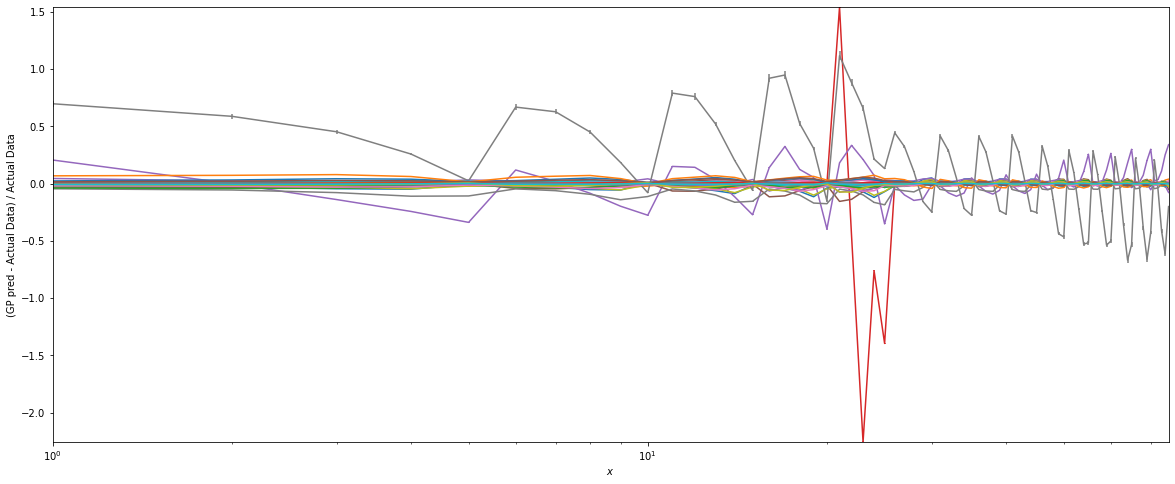

In [952]:
Diagnostic_Plots(new_column_list, Gpr_Pred, Gpr_Pred* Gpr_Std, y_test, np.zeros_like(y_test)).Plot_GPvsTrial()



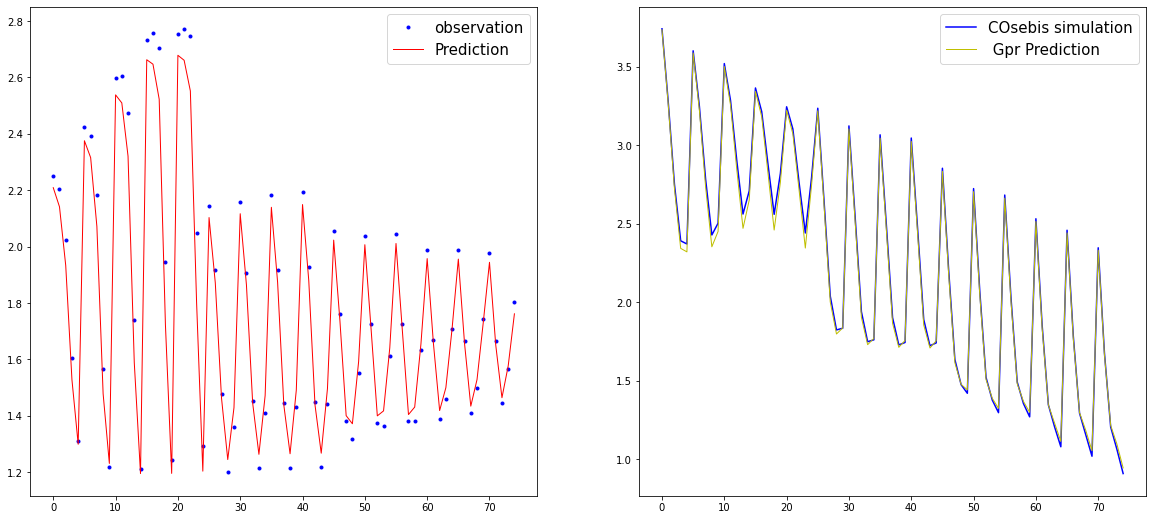

In [953]:
Diagnostic_Plots(new_column_list, Gpr_Pred, Gpr_Pred* Gpr_Std, y_test, np.zeros_like(y_test)).plot_sample()

In [954]:
DP1 = Diagnostic_Plots(new_column_list, Cv_pred, np.zeros_like(Cv_pred), y_train, np.zeros_like(y_train))

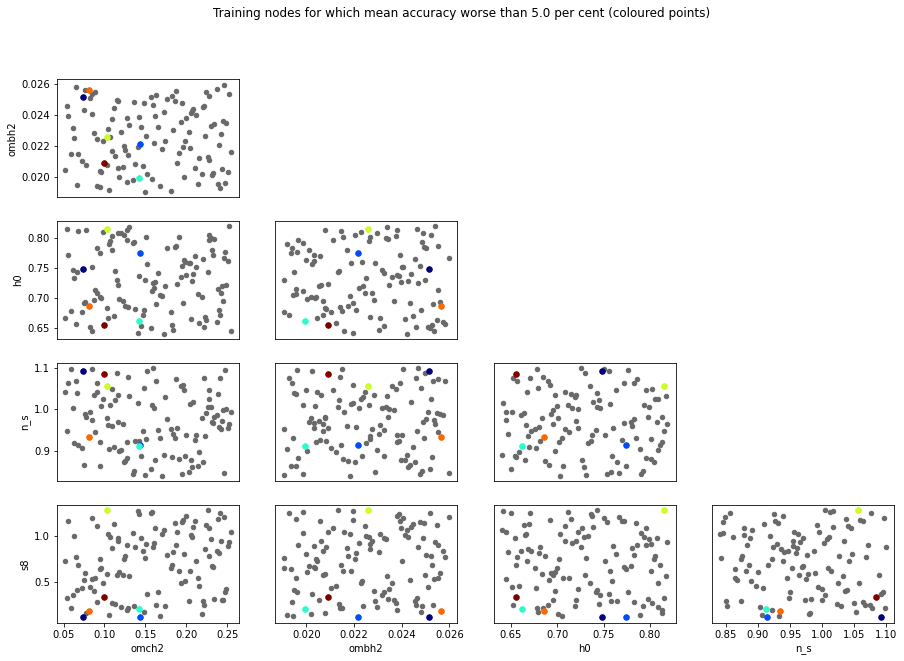

In [955]:
threshold =  5.0		# Highlight nodes less accurate than this % on average
labels = ['omch2','ombh2','h0','n_s' ,'s8']			# array of labels for nodes used in emulation. e.g. ['Omega_m', 'S_8',...]
limits = None			# Limits of training nodes used in plotting. e.g. [ [0.1,0.9], [0.7,0.9],...] 
# CVplotname2 = savedir + 'CVNodes_' + savename + '.png'

DP1.Plot_CV_Inacc(X_train,threshold,labels,limits)